In [40]:
import numpy as np
import pandas as pd
import os
print(os.getcwd())

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\matze\Documents\locandis


In [1110]:
def load_and_merge_files(path=os.getcwd()):
    '''
        Load all csv files in given directory and merges them
    '''
    #Initializing
    df_list = []
    filelist = os.listdir(path)
    csv_files = []
    dataframe = pd.DataFrame()
    
    #Subsets filelist to csv only
    for file in filelist:
        if file.endswith('.csv'):
            csv_files.append(file)
    
    #read each csv file and append it to the DataFrame
    for csv_file in csv_files:
        
        df_list.append(pd.read_csv('{path}/{filename}'.format(path = path,filename=csv_file),sep=';'))
    
    dataframe = pd.concat(df_list,ignore_index =True,verify_integrity=True)
    
    
    return dataframe

def typecasting(df,object_cols = [],numeric_cols=[],date_cols=[]):
    '''
        retype columns of a dataframe
    
    '''
    df[object_cols] = df[object_cols].astype('object')
    df[date_cols] = df[date_cols].astype('datetime64[s]')
    df[numeric_cols].apply(pd.to_numeric)
    
    return df

In [1320]:
df = load_and_merge_files('./Kassendaten')

In [1411]:
##preparation of the dataset
def data_cleaning(df):
    
    return (df.rename(str.lower, axis='columns').
     assign(umsatz_brutto = df['umsatz_brutto'].add(df['coupon_betrag'],fill_value =0)).
     drop(['coupon_menge',
           'coupon_kz',
           'coupon_zeile',
           'coupon_id',
           'coupon_betrag',
           'arthiertyp_id']
          , axis = 'columns').
     pipe(typecasting,date_cols=['bon_beginn','bon_ende'], object_cols=['kl_art_id','wgi_id','wg_id']).
     assign(bon_ende = lambda x: x['bon_ende']-x['bon_beginn']).
     rename(columns={'bon_ende':'bon_duration'})
     )





In [1412]:
df =  data_cleaning(df)
df.head()

,bon_id,bon_zeile,bon_beginn,bon_duration,umsatz_brutto,kl_art_id,wg_id,wg_bez,wgi_id,wgi_bez
0,'+5CQfkvfmASkY6To5d7iGA,1.0,2017-12-14 17:02:19,00:00:14,1.85,865643,470,Kosmetika,152,Coloration Stufe3
1,'+5CQfkvfmASkY6To5d7iGA,2.0,2017-12-14 17:02:19,00:00:14,1.85,865643,470,Kosmetika,152,Coloration Stufe3
2,'+5CQfkvfmASkY6To5d7iGA,3.0,2017-12-14 17:02:19,00:00:14,0.78,1.06572e+06,41,Milch/Mopro ungek.,210,"H-Milch 3,5% L Pk"
3,'+5CQfkvfmASkY6To5d7iGA,4.0,2017-12-14 17:02:19,00:00:14,0.78,1.06572e+06,41,Milch/Mopro ungek.,210,"H-Milch 3,5% L Pk"
4,'+5CQfkvfmASkY6To5d7iGA,5.0,2017-12-14 17:02:19,00:00:14,0.78,1.06572e+06,41,Milch/Mopro ungek.,210,"H-Milch 3,5% L Pk"


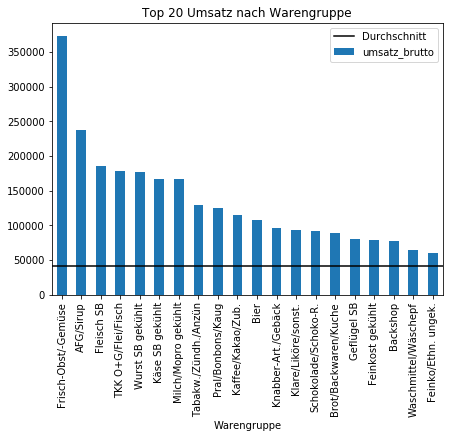

In [1734]:
#get top 20 'warengruppe'
top20_wg = (df.groupby(['wg_bez']).
            sum().
            loc[:,['umsatz_brutto']].
            sort_values('umsatz_brutto',ascending=False).
            head(20)
           )

#calculate avg_umsatz as reference
avg_wg_umsatz = df.groupby(['wg_bez'])['umsatz_brutto'].sum().mean()


#plot barchart
fig, ax = plt.subplots(figsize =(7,5))
top20_wg.plot.bar(ax = ax,title = "Top 20 Umsatz nach Warengruppe")
ax.axhline(avg_wg_umsatz,label="Durchschnitt",color='black')
ax.set(xlabel='Warengruppe')
ax.legend()



In [1603]:
def filter_pfand(df):
    return df.query('wg_bez != "Pfand"')

def ratio(df,enumerator,nominator):
    return df[enumerator]/df[nominator]

def ratio_rows(df,enumerator,nominator):
    return df.loc[enumerator]/df.loc[nominator]


In [1735]:
### mittlerer wg-wert wenn wg auf bon
### im schnitt wird in einer warengruppe x ausgegeben wenn sie auf dem bon erscheint
print(np.divide(df['umsatz_brutto'].sum(),
                (df.groupby('bon_id')['wg_bez'].
                    nunique().
                    sum()
                )
               )
     )

### Wie viel wird im Schnitt innerhalb einer WArengruppe gekauft wenn sie gekauft wird 
(df.pipe(filter_pfand).
 groupby('wg_bez').
 agg({'umsatz_brutto':'sum','bon_id':'nunique'}).
 pipe(ratio,enumerator = 'umsatz_brutto', nominator = 'bon_id').
 sort_values().
 head(10)
)

3.2623806646796787


wg_bez
Feinkost gek. Theke     0.240000
Schreib-/Büro-/Schul    0.820800
Zucker/Salz             1.169082
Backshop                1.412496
Margarine/Fette         1.480182
Sauerkonserven          1.546914
Gemüsekonserven         1.692049
Pudding/Dessert         1.698858
Eier                    1.852421
Teigwaren/Kartoffel     1.900909
dtype: float64

In [1736]:
### wie viele Artikel werden im schitt zusammen gekauft
df.groupby('bon_id')['kl_art_id'].nunique().mean()



10.067903984851439

In [1423]:
### mittlerer wg_wert
np.divide(df.pipe(filter_pfand)['umsatz_brutto'].sum(),
          (df.pipe(filter_pfand).
              groupby('bon_id')
              ['wg_bez'].
              nunique().
              sum()
          )
         )

3.559492839551951

In [1560]:
start = time.time()
(df.groupby('wg_bez').
 aggregate({'bon_id':'nunique','umsatz_brutto':'sum'}).
 rename(columns={'umsatz_brutto':'sum_umsatz_per_wg','bon_id':'count_bon_id'}).
 pipe(ratio,enumerator='sum_umsatz_per_wg',nominator='count_bon_id')
)
print(time.time()-start)

3.67236065864563


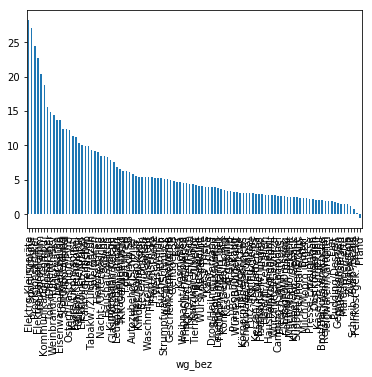

In [1389]:
avarage_wg_value.plot.bar()

AxesSubplot(0.125,0.125;0.775x0.755)


count    31.000000
mean     19.794842
std       2.756235
min      14.334088
25%      18.144844
50%      19.582729
75%      21.376309
max      26.858768
Name: umsatz_brutto, dtype: float64

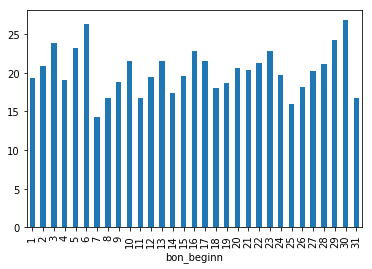

In [1739]:
#mittlerer bonwert im verlauf eines Monats
#ist der Mittelwert ller bonwerte uber ein gewisses zeitintervall
'''
avg_bon_value_month= (df.query('wg_bez != "Pfand"').
                      groupby(['bon_beginn','bon_id'])
                      ['umsatz_brutto'].
                      sum().
                      reset_index(1).
                      resample('D').
                      mean().reset_index().
                      assign(bon_beginn = lambda x: x['bon_beginn'].dt.day).
                      groupby('bon_beginn').
                      mean().plot.bar()
                      #rename
)
avg_bon_value_month

avg_bon_value_week= (df.query('wg_bez != "Pfand"').
                      groupby(['bon_beginn','bon_id'])
                      ['umsatz_brutto'].
                      sum().
                      reset_index(1).
                      resample('D').
                      mean().reset_index().
                      assign(bon_beginn = lambda x: x['bon_beginn'].dt.dayofweek).
                      groupby('bon_beginn').
                      mean()
)
avg_bon_value_week
'''
avg_bon_value_month= (df.groupby([df.bon_beginn.dt.day,'bon_id'])
                      ['umsatz_brutto'].
                      sum().mean(level='bon_beginn')
                     )

avg_bon_value_week= (df.groupby([df.bon_beginn.dt.dayofweek,'bon_id'])
                      ['umsatz_brutto'].
                      sum().mean(level='bon_beginn')
                     )
avg_bon_value_week.plot.bar()
avg_bon_value_month.plot.bar()
avg_bon_value_month.describe()

###vergleichen von druchschnitt aller monate mit nur einem vollständigen
###man sieht perioden vermutung weekly

In [246]:
#wahrscheinlich geht auch max bonzeile NEIN Kann nach filtern von pfdand nicht mehr verwendet werden

df.query('wg_bez != "Pfand"').groupby('bon_id').sum()['umsatz_brutto'].min()
#minimaler bonwert ohne pfand ist 0
#minimaler bonwert mit pfand -26.5 ohne pfand 0
#negativer umsatz außerhalb von pfand ist storno und sollte unbedingt drinnen bleiben!

0.0

In [1750]:
### werden bestimmte warengruppen besondersoft zu beginn eines monats gekauft
def ratio_beginn_end(df, target,bins):
    total_bons_per_target =  df.groupby([target])['bon_id'].nunique()
    return (df.groupby(['wg_bez',target])['bon_id'].
                          nunique().
                          divide(total_bons_per_target,level='bon_beginn').
                          unstack('wg_bez').
                          reset_index().
                          assign(bon_beginn = lambda x: pd.cut(x['bon_beginn'],
                                                               bins=bins,
                                                               labels=['beginn','end'],
                                                               include_lowest=True)).
                          groupby('bon_beginn').
                          mean().
                          pipe(ratio_rows, enumerator = 'beginn',nominator = 'end').
                          sort_values(ascending=False)
      )

df.pipe(ratio_beginn_end,target = df.bon_beginn.dt.dayofweek, bins = [0,1,5])
df.pipe(ratio_beginn_end,target = df.bon_beginn.dt.day, bins = [0,4,30])



wg_bez
Sport-Schuhe            1.424575
Kurzwaren/Wolle         1.194295
Nacht-/Unterwäsche      1.192837
Schuhe                  1.164100
Fahrrad-Zubehör         1.145186
Elektro-Saisonartik.    1.086868
Bücher/Brillen          1.075544
Strumpfwaren/Schmuck    1.041398
Preislagen              1.027326
Lederwaren              1.027127
Heimtextilien           1.023518
Haushaltswaren          1.008664
Backshop                0.999833
Sportbekleidung         0.998010
Schreib-/Büro-/Schul    0.988189
Fertiggerichte          0.972319
Tchibo-Artikel          0.970482
Tabakw./Zündh./Anzün    0.957592
Unterh.-Elektronik      0.955859
Tee/Instant/Zub.        0.954640
Autozubehör/Schmier     0.948741
Kaffee/Kakao/Zub.       0.934402
Pfand                   0.925723
Camping-/Gartenmöbel    0.922039
Käse Theke              0.920919
Drog/Heilmit/Verband    0.918855
Waschmittel/Wäschepf    0.917622
AFG/Sirup               0.915930
Garten                  0.913806
Frisch-Obst/-Gemüse     0.908644
   

In [1743]:
#### verhältnis am anfang gekaufter werte vs am ende gekaufter werte
def clipper_week(df,bins=[0,1,5]):
    return pd.cut(df,labels=['beginn','end'],bins=bins,include_lowest=True)
start = time.time()

def ratio_beginn_end(df, target,bins):
    total_bons_per_target =  df.groupby([target])['bon_id'].nunique()
    return (df.groupby(['wg_bez',target])['bon_id'].
                          nunique().
                          divide(total_bons_per_target,level='bon_beginn').
                          unstack('wg_bez').
                          reset_index().
                          assign(bon_beginn = lambda x: pd.cut(x['bon_beginn'],
                                                               bins=bins,
                                                               labels=['beginn','end'],
                                                               include_lowest=True)).
                          groupby('bon_beginn').
                          mean().
                          pipe(ratio_rows, enumerator = 'beginn',nominator = 'end').
                          sort_values(ascending=False)
      )
    

total_bons_per_weekday =  df.groupby([df.bon_beginn.dt.dayofweek])['bon_id'].nunique()
total_bons_per_day =  df.groupby([df.bon_beginn.dt.day])['bon_id'].nunique()

bons_per_weekday_in_wg = (df.groupby(['wg_bez',df.bon_beginn.dt.dayofweek])['bon_id'].
                          nunique().
                          divide(total_bons_per_weekday,level='bon_beginn').
                          unstack('wg_bez').
                          reset_index().
                          assign(bon_beginn = lambda x: pd.cut(x['bon_beginn'],
                                                               bins=[0,1,5],
                                                               labels=['beginn','end'],
                                                               include_lowest=True)).
                          groupby('bon_beginn').
                          mean().
                          pipe(ratio_rows, enumerator = 'beginn',nominator = 'end').
                          sort_values(ascending=False)
      )

bons_per_day_in_wg = (df.groupby(['wg_bez',df.bon_beginn.dt.day])['bon_id'].
                          nunique().
                          divide(total_bons_per_day,level='bon_beginn').
                          unstack('wg_bez').
                          reset_index().
                          assign(bon_beginn = lambda x: pd.cut(x['bon_beginn'],
                                                               bins=[0,4,30],
                                                               labels=['beginn','end'],
                                                               include_lowest=True)).
                          groupby('bon_beginn').
                          mean().
                          pipe(ratio_rows, enumerator = 'beginn',nominator = 'end').
                          sort_values(ascending=False)
      )
print(time.time()-start)
bons_per_weekday_in_wg

##an wie vielen Tagen wurden bestimmte warengruppen gekauft
(df.assign(bon_beginn = lambda x: x['bon_beginn'].dt.date).
 groupby('wg_bez')['bon_beginn'].
 nunique().
 sort_values().
 div(df['bon_beginn'].dt.date.nunique())
)
##complete
None
bons_per_day_in_wg

13.45202922821045


wg_bez
Elektro-Saisonartik.    2.563856
Fischkonserv. ungek.    2.466272
Sportartikel            2.205093
Farben/Kleinmöbel       2.170381
Unterh.-Elektronik      2.089286
Elektro-Kleingeräte     2.004166
Sport-Schuhe            1.613143
Schuhe                  1.571494
Nacht-/Unterwäsche      1.533065
Garten                  1.499142
Eisenwaren/Werkzeuge    1.433994
Konfit./Gelee/Honig     1.415114
Putz-/Reinig.Mittel     1.406029
Heimtextilien           1.393770
Teigwaren/Kartoffel     1.295994
Fertiggerichte          1.293340
Provisionsartikel       1.272412
Besen/Bürsten           1.225196
Margarine/Fette         1.205806
Butter                  1.204875
Leuchtmittel/Lampen     1.203658
Drog/Heilmit/Verband    1.195439
Kommunikation/Compu.    1.189026
TKK Geflügel/Wild       1.168293
TKK O+G/Flei/Fisch      1.146831
Elektroinst.-Artikel    1.144649
Tiernahrung/-zubehör    1.140744
Knabber-Art./Gebäck     1.139267
Fleisch-/Wurstkons.     1.137767
Pudding/Dessert         1.131485
   

In [1724]:
def clipper_week(df,bins=[0,1,5]):
    return pd.cut(df,labels=['beginn','end'],bins=bins,include_lowest=True)
start=time.time()
total_bons_per_weekday =  df.groupby(clipper_week(df.bon_beginn.dt.dayofweek))['bon_id'].nunique()
bons_per_weekday_in_wg = (df.assign(bon_beginn = clipper_week(df['bon_beginn'].dt.dayofweek)).
                          groupby(['wg_bez','bon_beginn'])['bon_id'].
                          nunique().
                          divide(total_bons_per_weekday,level='bon_beginn').
                          unstack('wg_bez').
                          pipe(ratio_rows, enumerator = 'beginn',nominator = 'end').
                          sort_values(ascending=False)
                          
                        
      )
print(time.time()-start)
bons_per_weekday_in_wg

7.4258644580841064


wg_bez
Nacht-/Unterwäsche      1.214309
Fahrrad-Zubehör         1.172231
Schuhe                  1.171762
Kurzwaren/Wolle         1.163716
Bücher/Brillen          1.073649
Strumpfwaren/Schmuck    1.038317
Preislagen              1.034979
Sportbekleidung         1.023175
Heimtextilien           1.022730
Lederwaren              1.014112
Backshop                0.999676
Haushaltswaren          0.998236
Schreib-/Büro-/Schul    0.979971
Fertiggerichte          0.963822
Tchibo-Artikel          0.958667
Tabakw./Zündh./Anzün    0.947454
Tee/Instant/Zub.        0.941968
Unterh.-Elektronik      0.939469
Sport-Schuhe            0.927188
Autozubehör/Schmier     0.924935
Kaffee/Kakao/Zub.       0.919000
Garten                  0.917985
Pfand                   0.915396
Käse Theke              0.910277
AFG/Sirup               0.904580
Drog/Heilmit/Verband    0.901982
Farben/Kleinmöbel       0.895758
Waschmittel/Wäschepf    0.894650
Camping-/Gartenmöbel    0.893625
Milch/Mopro gekühlt     0.892836
   

In [1564]:
###Umsatzeffizienz

In [1129]:
from scipy import stats
    
(df.groupby('kl_art_id')['umsatz_brutto'].
 agg([('count','count'),
      ('modus',lambda x: stats.mode(x)[0]),
      ('frequ',lambda x: stats.mode(x)[1])]
    )
)

,count,modus,frequ
kl_art_id,,,
10006.0,639,3.99,545.0
10038.0,46,3.39,14.0
10048.0,44,4.67,2.0
10061.0,54,2.79,11.0
10069.0,156,5.22,5.0
10115.0,117,3.94,7.0
10306.0,4,41.59,1.0
10314.0,53,5.10,3.0
10359.0,104,2.94,4.0


In [1731]:
(df.loc[df['wg_id']<=430].
 groupby('kl_art_id').
 agg({'umsatz_brutto':'sum','bon_id':'nunique'}).
 pipe(ratio,enumerator='umsatz_brutto',nominator='bon_id').sort_values(ascending=False)
)

kl_art_id
1900406.0    114.967143
850546.0      71.225000
1941944.0     59.970000
1108449.0     59.875000
10306.0       56.933333
10524.0       55.693333
880181.0      52.488750
1120867.0     52.485000
700690.0      52.450000
1066153.0     50.483333
1017667.0     49.990000
1089234.0     49.000000
1079391.0     47.127857
1912179.0     46.990000
700716.0      45.950000
1140787.0     42.785000
1035621.0     42.396875
2103729.0     41.987273
866463.0      41.691702
2028258.0     40.140000
881026.0      39.990000
2104073.0     39.990000
2103125.0     39.990000
1061959.0     39.900000
2405991.0     38.465000
866454.0      37.990000
1120888.0     35.990000
993358.0      35.760000
2100408.0     34.990000
867724.0      34.990000
                ...    
925810.0       0.209079
2312787.0      0.200000
602514.0       0.192829
1146999.0      0.181250
943421.0       0.158148
1099792.0      0.152620
1099766.0      0.150667
1099789.0      0.146829
2602498.0      0.090000
1095474.0      0.036000
345509

In [1300]:
### gibt es ein muster in den wgi_ids bzw wg_ids um zu erkennen ob etwas ein lebensmittel ist ==> ja kleiner als 430


###versuch preis zu errechenen
(df.loc[df['wg_id']<=430].query('umsatz_brutto >= 0').
 groupby(['wg_bez','wgi_bez','kl_art_id'])['umsatz_brutto'].agg(['count','nunique','min','mean','median',lambda x: stats.mode(x)[0]])
 #sort_values(['nunique'],level='wg_bez')
 .query('nunique > 10')
)

count  \
wg_bez               kl_art_id wgi_bez                                          
AFG/Sirup            893072.0  Cola/Colamix-Limonaden                    5549   
                     893076.0  Light Limonaden Cola/Cola-Mix             1194   
                     893077.0  Cola/Colamix-Limonaden                     530   
                     893078.0  Orangenlimonade                           1918   
                     893079.0  Zitronenlimonade                          1231   
                     893080.0  Cola/Colamix-Limonaden                    1044   
                     893081.0  Cola/Colamix-Limonaden                    1070   
                     893083.0  Light Limonaden Cola/Cola-Mix              114   
                     893084.0  Orangenlimonade                            262   
                     930996.0  Cola/Colamix-Limonaden                     708   
                     969272.0  Mineralwasser Medium                        54   
                     971316.0  Sonstige Limonaden                         296   
                     971989.0  Mineralwasser Still                       4558   
                     971992.0  Mineralwasser Still                       3038   
                     1019715.0 Orangensaft                                541   
                     1024191.0 Sonstige Limonaden                         376   
                     1066183.0 Energydrink Dose                          6488   
                     1082086.0 Apfelsaft                                  890   
                     1083734.0 Energydrink Dose                          2538   
                     1083774.0 Energydrink Dose                           671   
                     1083781.0 Energydrink Dose                           799   
                     1083784.0 Energydrink Dose                          1665   
                     1099765.0 Mineralwasser Still                       1059   
                     1101442.0 Zitronenlimonade                           684   
                     1123067.0 Cola/Colamix-Limonaden                     192   
                     1123095.0 Cola/Colamix-Limonaden                     178   
                     2000741.0 Mineralwasser Classic                      437   
                     2000790.0 Light Limonaden Cola/Cola-Mix              538   
                     2000794.0 Cola/Colamix-Limonaden                     497   
                     2000796.0 Light Limonaden Cola/Cola-Mix              215   
...                                                                       ...   
Tiernahrung/-zubehör 3425428.0 Katze nass all meat 85g Dose               198   
                     3431926.0 Katze nass all meat 85g Dose               182   
                     3467032.0 Katze nass all meat 85g Dose               211   
                     3472876.0 Katze nass all meat 85g Dose               173   
Weissweine           946671.0  AW Spanien, La Mancha                      382   
                     1803253.0 unbek WUG zu WG   180                       21   
                     1806488.0 Pfalz                                      320   
Wurst SB gekühlt     118547.0  unbek WUG zu WG    12                       26   
                     118980.0  Kochschinken Stück                          72   
                     133185.0  Bauch roh geschnitten                     3870   
                     133298.0  sonstige Convenience                        97   
                     160681.0  Geflügel Schenkel/ Teile                   156   
                     859799.0  sonstige Brühwurst                         740   
                     879226.0  Schinkenspeck geräuchert geschnitten        29   
                     906919.0  Geflügel Brust/ Schinken gegart Stück      190   
                     918122.0  Kochschinken Natur geschnitten            5760   
                     1019402.0 Geflügel Brust/ Schinken gegart Stück       81   
                     1

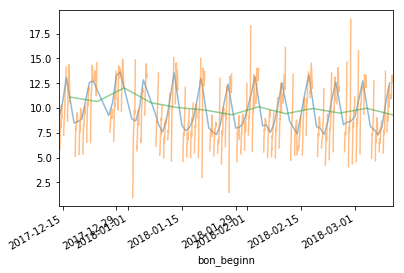

In [1482]:
### Zeitreihendaten
art_per_bon = df.groupby(['bon_beginn','bon_id'])['kl_art_id'].nunique()

#Plotting
art_per_bon.resample('D',level='bon_beginn').mean().dropna().plot(alpha=0.5)
art_per_bon.resample('H',level='bon_beginn').mean().rolling('3h').mean().plot(alpha=0.5)
art_per_bon.resample('W',level='bon_beginn').mean().dropna().plot(alpha=0.5)

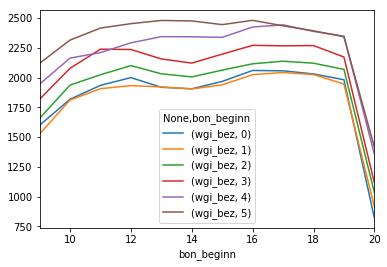

In [1521]:
(df.query('bon_beginn.dt.hour > 8').
 groupby([df.bon_beginn.dt.dayofweek,df.bon_beginn.dt.hour]).
 aggregate({'wgi_bez':'nunique'}).
 unstack(level=0).plot())

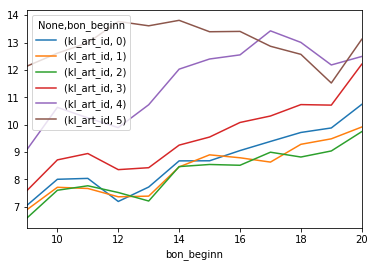

In [1535]:
#durchschittliche artikel pro warenkorb im tages bzw wochenverlauf
(df.query('bon_beginn.dt.hour > 8').
 groupby([df.bon_beginn.dt.dayofweek,df.bon_beginn.dt.hour,'bon_id']).
 aggregate({'kl_art_id':'nunique'}).mean(level=[0,1]).unstack(level=0).plot()
)

df.columns.droplevel(0)

In [1542]:
(df.query('bon_beginn.dt.hour > 8').
 groupby([df.bon_beginn.dt.dayofweek,df.bon_beginn.dt.hour,'bon_id']).
 aggregate({'kl_art_id':'nunique'}).mean(level=[0,1]).unstack(level=0).columns.droplevel(0))

AttributeError: 'Int64Index' object has no attribute 'columns'